MAURY Jocelyn N°2183813

# 2. Création de l'architecture de l'AEVB sous python en OOP

A présent, je vais chercher à mettre en place un AEVB. Ce réseau de neurones prend des données $x$ en entrée. Il en ressort de nouvelles données $x$. Entre ces deux étapes, les données vont être réduites en dimensionalité dans l'espace latent. Puis, la nouvelle donnée sera tiré à partir d'une loi choisi au départ et reparamétrisée. Enfin, le réseau de neurones cherchera à minimser l'erreur entre la donnée d'entrée et la donnée de sortie. L'intérêt de l'AEVB sur l'AE classique est que l'étape de sampling permet d'ajouter une variante probabiliste au modèle servant de régularisation au modèle aifn d'éviter l'overfitting. De plus, il est possible de se servir de cette loi et des paramètres de la loi appris par le réseau de neurones pour générer de nouvelles données. 

Schématiquement, l'AEVB se présente comme suit : 

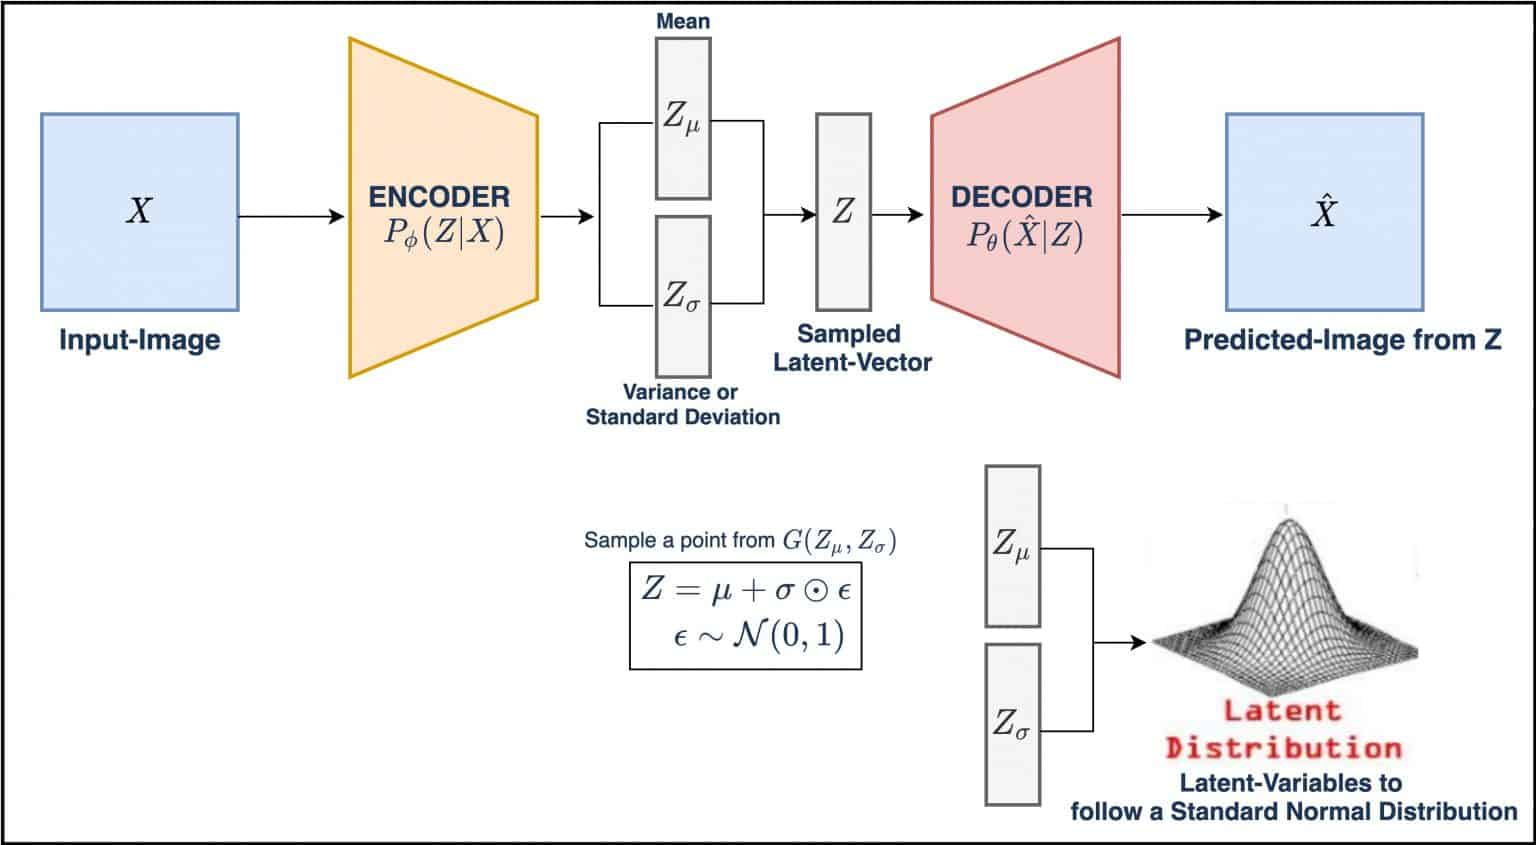

Source : https://learnopencv.com/variational-autoencoder-in-tensorflow/

L'architecture du modèle peut être impacté par le format des données qui seront insérées dans le modèle. Par conséquent, je décide de choisir dès à présent mes données d'entrées. Il s'agit des données MNIST. J'ai choisi ces données car ce sont celles qui sont le plus utlisées dans les exemples de ce réseau de neurones. Ainsi, il est plus facile de trouver des ressources. 

Je commence par charger les packages qui me seront utilies lors du développement :  

In [2]:
import numpy as np 
import jax 
import jax.numpy as jnp 
from jax import random 
from flax import linen as nn 
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

Ensuite, je charge les données mnist : 

In [3]:
# Désactivation de tout les GPU pour être sûr d'utiliser le CPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Je met la batch_size à 1 car je ne maitrise pas bien cet argument. 
# Je préfère avoir des batchs de 1 image pour le moment
BATCH_SIZE = 1

def prepare_image(x):
    x = tf.cast(x['image'], tf.float32)  # Convertit l'image en float32
    x = tf.reshape(x, (-1,))  # Aplatit l'image en un vecteur 1D
    return x

ds_builder = tfds.builder('binarized_mnist')  # Crée un constructeur de dataset pour MNIST binarisé
ds_builder.download_and_prepare()  # Télécharge et prépare le dataset

train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)  # Crée un dataset d'entraînement à partir du split TRAIN
train_ds = train_ds.map(prepare_image)  # Applique la fonction prepare_image à chaque élément du dataset
train_ds = train_ds.cache()  # Met en cache le dataset pour une récupération plus rapide
train_ds = train_ds.repeat()  # Répète le dataset indéfiniment
train_ds = train_ds.shuffle(50000)  # Mélange les éléments du dataset
train_ds = train_ds.batch(BATCH_SIZE)  # Crée des lots de données de taille BATCH_SIZE
train_ds = iter(tfds.as_numpy(train_ds))  # Convertit le dataset en un itérable numpy

test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)  # Crée un dataset de test à partir du split TEST
test_ds = test_ds.map(prepare_image).batch(10000)  # Applique la fonction prepare_image à chaque élément du dataset et crée un lot de taille 10000
test_ds = np.array(list(test_ds)[0])  # Convertit le dataset en un tableau numpy

In [4]:
# Je vérifie que le dataset est bien chargé
image = next(train_ds) # Récupère une image du dataset
first_image = image[0, :784] # Je récupère l'image (ce sont des images 28x28 donc un vecteur à plat de 728)
# Attention, image se sert d'un objet itératif
# Donc si je veux utiliser l'entiereté du dataset, 
# je dois le recharger pour avoir un itérateur qui repart du début 
print(first_image.shape)

(784,)


In [5]:
# Comme j'ai enregistré la première image, 
# je n'ai plus besoin d'utiliser l'itérateur 
print(first_image.shape)

(784,)


L'objet semble correspondre à ce que j'en attend. Je peux utiliser une fonction d'affichage d'image pour vérifier : 

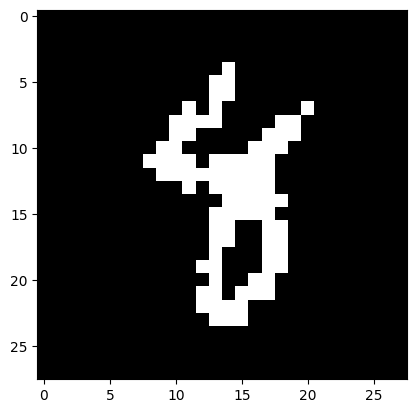

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def display_image(image_vector):
    if len(image_vector) != 784:
        raise ValueError("L'image doit être un vecteur de taille 784.")
    
    image_matrix = np.reshape(image_vector, (28, 28))
    
    plt.imshow(image_matrix, cmap='gray')
    plt.show()

display_image(first_image)

Tout semble correct. 
A présent, je vais créer une classe Encoder qui me permettra de créer un AEVB modulable.

In [7]:
class Encoder(nn.Module):
    # Définit le nombre de couches du réseau
    n_layers : int  
    # Définit la dimension de l'espace latent 
    dim_latente : int  


    def setup(self):
        # Crée une couche dense d'entrée avec le nombre de couches spécifié
        self.nn_entree = nn.Dense(self.n_layers, name='couche entree')  
        # Crée une couche dense pour calculer la moyenne de l'espace latent
        self.nn_latent_mean = nn.Dense(self.dim_latente, name='moyenne')  
        # Crée une couche dense pour calculer la log variance de l'espace latent
        self.nn_logvar_mean = nn.Dense(self.dim_latente, name='log_variance')  

    def __call__(self, x_entree): 
        # Passe les données d'entrée à travers la couche d'entrée
        x = self.nn_entree(x_entree)  
        # Applique la fonction d'activation ReLU
        x = nn.relu(x)  
        # Calcule la moyenne de l'espace latent à partir de la sortie de la couche d'entrée
        mean_x = self.nn_latent_mean(x)  
        # Calcule la log variance de l'espace latent à partir de la sortie de la couche d'entrée
        logvar_x = self.nn_logvar_mean(x)  
        # Retourne la moyenne et la log variance de l'espace latent
        return mean_x, logvar_x

Cela correspond à la première étape du modèle : 
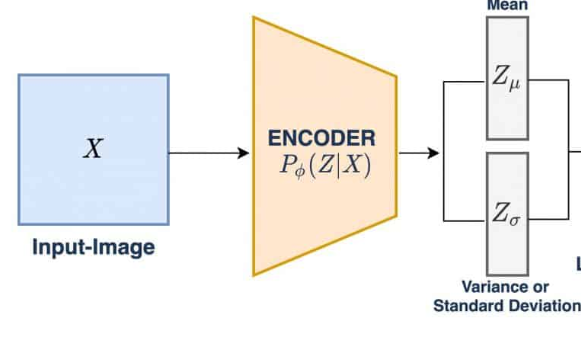

In [8]:
# Je test ma classe Encoder : 
dim_latente = 2
# dim_latente = 2 car on veut un espace latent de dimension 2 
# pour la représentation visuelle 
encoder = Encoder(n_layers=267, dim_latente=dim_latente)

seed = 7 
key = random.PRNGKey(seed)
key, subkey = random.split(key)

# Initialisation des paramètres du modèle à 1
params = encoder.init(subkey, jnp.zeros((1, 784)))

# Test en appelant la méthode __call__ via apply
test_mean, test_logvar = encoder.apply(params, first_image)

print("Mean:", test_mean)
print("Log Variance:", test_logvar)

Mean: [ 0.06094885 -0.18602553]
Log Variance: [0.10719228 0.17948845]


L'encoder semble bien fonctionné. Pour une image en entrée, il initiliase ses paramètres à 1 et ressort une moyenne ainsi qu'une variance estimée en 2 dimensions. 

Ensuite, je définis une fonction de sampling à partir des paramètres éstimés par mon encoder : 

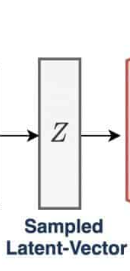

In [9]:
# Sampling de z à partir d'une gaussienne reparamétrisée 
# + moyenne et variance estimée par NN
# Je créer un paramètre de batching même 
# si je procédérais image par image pour commencé
def sampling_espace_latent(key, taille_du_batch, moyenne, log_variance, dim_latente):
    #Reparamétrisation de la gaussienne  
    epsilon = random.normal(key, (taille_du_batch, dim_latente))
    std = jnp.exp(0.5 * log_variance)
    return moyenne + epsilon * std

In [10]:
# Je test la fonction de sampling
key, subkey = random.split(key)

image_samplee = sampling_espace_latent(subkey, 1, test_mean,test_logvar, dim_latente=dim_latente)  # test de la fonction
image_samplee

Array([[ 0.95379364, -1.1690127 ]], dtype=float32)

La fonction permet bien de générer une nouvelle donnée à partir de la loi et des paramètres de l'espace latent. 

La suite du modèle consiste à faire passer cette nouvelle donnée générer dans le décodeur afin de projeter cette donnée dans l'espace de départ. Pour ce faire, je créer une classe Decoder : 

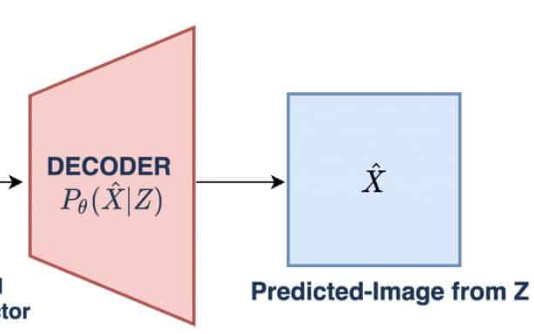

In [11]:
# Définition de la classe Decodeur qui hérite de nn.Module
class Decodeur(nn.Module): 
    # Déclaration de l'attribut n_layers qui représente le nombre de neurones dans la couche cachée
    n_layers : int 
    # Déclaration de l'attribut dim_depart qui représente la dimension de l'entrée originale
    dim_depart : int

    # Décorateur nn.compact qui permet de définir le modèle de manière concise
    @nn.compact
    # Définition de la méthode __call__ qui est appelée quand on appelle l'instance de la classe
    def __call__(self, x_encode_sampling): 
        # Création d'une couche dense (fully connected) avec self.n_layers neurones et application à x_encode_sampling
        x_projete = nn.Dense(self.n_layers, name='projection espace latent')(x_encode_sampling)
        # Application de la fonction d'activation ReLU à la sortie de la couche dense
        x_projete_post_activation = nn.relu(x_projete)
        # Création d'une autre couche dense qui ramène la dimension à self.dim_depart et application à la sortie de la couche ReLU
        x_decode = nn.Dense(self.dim_depart, name='couche de sortie')(x_projete_post_activation)
        # Retourne la sortie du décodeur
        return x_decode[0]
        

(784,)


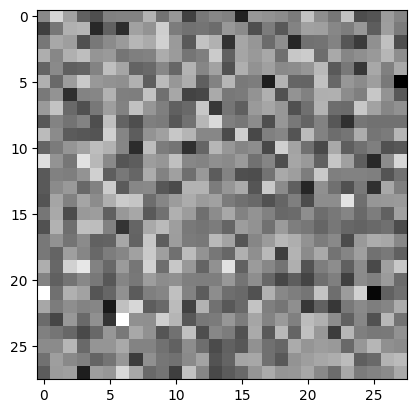

In [12]:
# #Test du decodeur 
key, subkey = random.split(key)
dim_latente = 2 
decodeur = Decodeur(n_layers=267, dim_depart=len(first_image))
params_decodeur = decodeur.init(subkey, jnp.ones((1, dim_latente)))
image_decode = decodeur.apply(params_decodeur, image_samplee)
print(image_decode.shape)
display_image(image_decode)

Le decodeur semble bien fonctionné. L'image de départ et d'arrivée sont très différente ce qui est normal car le réseau n'est pas encore entraîné. 
A présent, je vais combiner l'architecture déjà créer dans une nouvelle classe : Le VAE 

In [13]:
# Définition de la classe VAE (Auto-Encodeur Variationnel) qui hérite de nn.Module
class VAE(nn.Module):
    # Déclaration des attributs de la classe
    # Nombre de neurones dans la couche cachée de l'encodeur
    n_layers_encoder : int  
    # Dimension de l'espace latent
    dim_latente : int  
    # Nombre de neurones dans la couche cachée du décodeur
    n_layers_decoder : int 
    # Dimension de l'entrée originale
    dim_depart : int  

    # Méthode setup appelée lors de l'initialisation de l'instance de la classe
    def setup(self):
        # Initialisation de l'encodeur avec le nombre de neurones spécifié et la dimension de l'espace latent
        self.encoder = Encoder(self.n_layers_encoder, self.dim_latente)
        # Initialisation du décodeur avec le nombre de neurones spécifié et la dimension de l'entrée originale
        self.decodeur = Decodeur(self.n_layers_decoder, self.dim_depart)

    # Méthode forward qui définit le passage en avant dans le réseau
    def forward(self, x_entree, key): 
        # L'encodeur prend en entrée x_entree et retourne la moyenne et la variance logarithmique
        mean_x, logvar_x = self.encoder(x_entree)
        # Échantillonnage de l'espace latent pour obtenir z
        z = sampling_espace_latent(key, 1, mean_x, logvar_x, self.dim_latente)
        # Le décodeur prend en entrée z et retourne x_decode
        x_decode = self.decodeur(z)
        # Retourne x_decode, mean_x et logvar_x
        return x_decode, mean_x, logvar_x

    # Méthode __call__ qui est appelée quand on appelle l'instance de la classe
    def __call__(self, x_entree, key, training=True):
        if training: 
            # Appelle la méthode forward et récupère x_decode, mean_x et logvar_x
            x_decode, mean_x, logvar_x = self.forward(x_entree, key)
            # Retourne x_decode, mean_x et logvar_x
            return x_decode, mean_x, logvar_x
        else : 
            # Appelle la méthode encode et récupère mean_x et logvar_x
            x_decode = self.decodeur(x_entree)
            # Retourne mean_x et logvar_x
            return x_decode 

forme de x (784,), moyenne [-0.03840375  0.14612645], logvariance : [0.16780889 0.33271888]


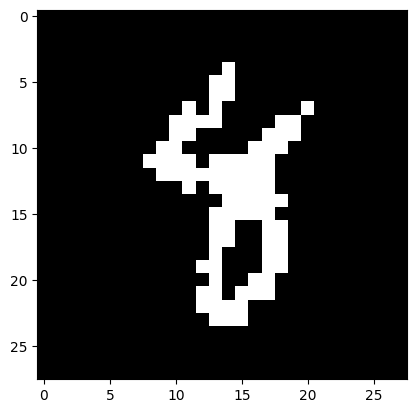

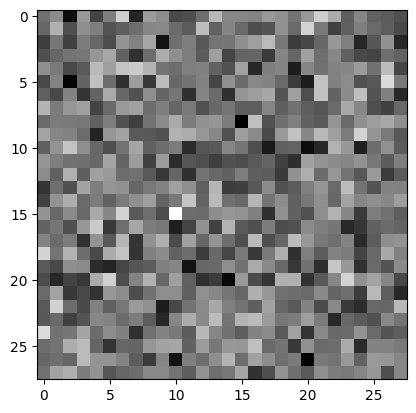

In [14]:
# Test du VAE : 
key, subkey = random.split(key)
model_vae = VAE(n_layers_encoder=267, dim_latente=dim_latente, n_layers_decoder=267, dim_depart=784)
params_vae = model_vae.init(subkey, jnp.ones((1,784)), subkey)
x_decode, mean_x, logvar_x = model_vae.apply(params_vae, first_image, subkey)
print(f"forme de x {x_decode.shape}, moyenne {mean_x}, logvariance : {logvar_x}")
display_image(first_image)
display_image(x_decode)

La structure du VAE semble correct. Je peux faire passer une donnée dans le modèle puis estimer des paramètres à partir de celle-ci. Ensuit, je peux opérer un sampling à partir de ces paramètres, puis cette nouvelle donnée est décodée pour redevenir une donnée de grande dimension. A présent, mon but est de créer une fonction de cout permettant au modèle de mesurer la différence entre la donnée de départ et celle d'arrivée. Grace à cette valeur, le modèle pourra ensuite ajuster ses paramètres par backpropagation. 

L'erreur de reconstruction est définie par la KL divergence et l'ELBO : 

In [15]:
# Définition de la fonction KL_divergence qui calcule la divergence KL entre deux distributions gaussiennes
def KL_divergence(mean_x, logvar_x): 
    # Calcul de la divergence KL selon la formule donnée
    return -0.5 * jnp.sum(1 + logvar_x - jnp.square(mean_x) - jnp.exp(logvar_x))

# Définition de la fonction reconstruction_error_loss qui calcule l'erreur de reconstruction
def reconstruction_error_loss(x_estime, x_reel): 
    # Définition de la fonction binary_cross_entropy_with_logits qui calcule l'entropie croisée binaire
    # pertinent car on travaille avec des images
    def binary_cross_entropy_with_logits(image_estimee, image_reelle):
        # Calcul du log-sigmoid des logits
        image_estimee = nn.log_sigmoid(image_estimee)
        # Calcul de l'entropie croisée binaire
        return -jnp.sum(image_reelle * image_estimee + (1. - image_reelle) * jnp.log(-jnp.expm1(image_estimee)))
    # Appel de la fonction binary_cross_entropy_with_logits avec x_entree et x_sortie
    return binary_cross_entropy_with_logits(x_estime, x_reel)

# Définition de la fonction loss_fn_negative_Elbo qui calcule la fonction de perte 
def entrainement(optimizer, opt_state, x_input, subkey, params_vae):
    x_estime, mean_x, logvar_x = model_vae.apply(params_vae, x_input, subkey)
    def loss_fn_negative_Elbo(params_vae): 
        # Appel du modèle VAE avec les paramètres
        x_estime, mean_x, logvar_x = model_vae.apply(params_vae, x_input, subkey)
        # Calcul de la divergence KL
        kld_loss = KL_divergence(mean_x, logvar_x)
        # Calcul de l'erreur de reconstruction
        reconstruction_erorr = reconstruction_error_loss(x_estime, x_input)
        # Calcul de la fonction de perte totale
        loss_totale = -(-kld_loss - reconstruction_erorr)
        # Retourne la fonction de perte totale
        return loss_totale
    
    loss, grads = jax.value_and_grad(loss_fn_negative_Elbo)(params_vae)
    updates, opt_state = optimizer.update(grads, opt_state, params_vae)
    params_vae = optax.apply_updates(params_vae, updates)

    return optimizer, loss, params_vae, mean_x, logvar_x

In [28]:
# Je test la fonction d'entrainement
from itertools import islice
# Test du VAE : 
seed = 7 
key = random.PRNGKey(seed)
key, subkey = random.split(key)
model_vae = VAE(n_layers_encoder=267, dim_latente=3, n_layers_decoder=267, dim_depart=784)
params_vae = model_vae.init(subkey, jnp.ones((1,784), jnp.int32), subkey)
solver = optax.adamw(learning_rate=0.003)
opt_state = solver.init(params_vae)
optimizer = optax.adam(1e-3).init(params_vae)

key, subkey = random.split(key)

training_size = 10_000
for i, image in enumerate(islice(train_ds, training_size)):
    image_input = image[0, :784]
    optimizer, _, params_vae, mean_x, logvar_x = entrainement(solver, opt_state, image_input, subkey, params_vae)

    # Afficher un message toutes les 500 images
    if i % 100 == 0 and i != 0:
        print(f"Calcul en cours, image {i} sur {training_size}")
        print(params_vae['params']['decodeur']['couche de sortie']['bias'][0])

Calcul en cours, image 100 sur 200
-0.3029509


Le modèle est bien entraîné. Je vais voir s'il reconstruit bien les images du dataset de test : 

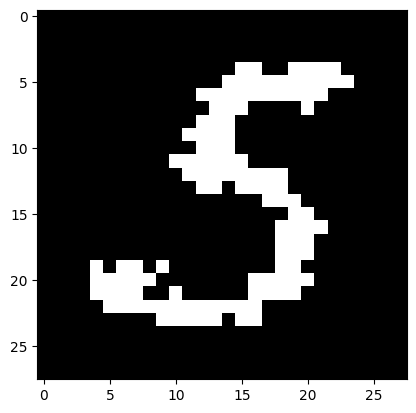

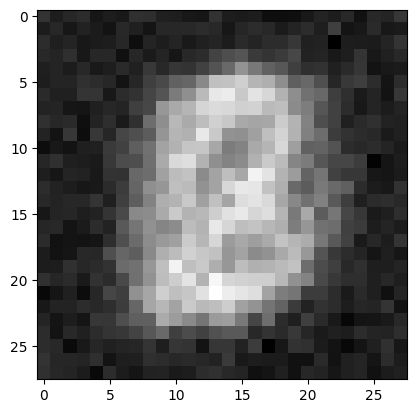

In [17]:
# Charger une image de test
test_image = test_ds[1]

x_estime, mean_x, logvar_x = model_vae.apply(params_vae, test_image, subkey)

display_image(test_image)
display_image(x_estime)

Les résultats ne sont pas très probant. Cependant, il pourra être intéressant d'étudier les résultats lorsque le modèle aura pu être entraîné sur l'entiereté du dataset. 

J'ai également essayer de construire un générateur d'image en reprenant la partie sampling et decodeur du modèle : 

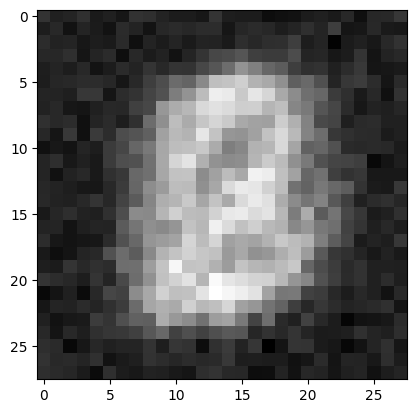

In [18]:
key, subkey = random.split(key)
x_genere = sampling_espace_latent(subkey, 1, mean_x, logvar_x, 3)
x_estime= model_vae.apply(params_vae, x_genere, subkey, False)
display_image(x_estime)


Les nombres générés ne ressemblent pas à des vrais nombres mais il est possible de suggérer un nombre plus ou moins distincts, parfois 3, parfois 9, parfois 8. 
Il serait intéressant d'explorer ces résultats. 

Il est également possible de faire de la réduction de dimension si on ne prend que la partie encodeur du modèle. 

La partie discutant du modèle est disponible sur le notebook : Rendu Projet AEVB.ipynb